# 02_EDA_and_Statistics.ipynb


##  Notebook Overview and Objectives

This notebook aims to perform deeper Exploratory Data Analysis (EDA) and statistical validation, building upon the initial data understanding completed in the first notebook.

We will conduct a structured analysis of both **categorical and numerical features**, focusing not only on their individual distributions but also on their **interactions with the target variable** (`loan_status`). Particular attention will be given to detecting patterns, class imbalances, and variable relationships that may impact credit risk.

We will also assess the **statistical significance** of these relationships to identify the most relevant variables for predictive modeling, while keeping visual clarity and analytical precision as top priorities.

### Goals:
- Visualize and analyze distributions, relationships, and patterns.
- Explore how categorical variables interact with the target and assess their influence on loan default.
- Identify correlations, interactions, and clusters in the data.
- Perform statistical tests to validate assumptions and support future modeling decisions.

## Import dependecies and load data 

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
from scipy.stats import chi2_contingency, fisher_exact

In [3]:
data = pd.read_csv(r"C:\Users\amine\Desktop\Gestion des Projets\Credit Risk Assessment Model\Data\credit_risk_dataset.csv")

## Categorical Variable Analysis

### Distribution of Categorical Features

In [6]:
def plot_categorical_feature(data, column, chart_type='bar', color='#4C72B0', title=None, annotate=True, sort=True, highlight=None):
    """
    Plots a clean, professional bar chart or pie chart for a categorical feature.

    Parameters:
    - data: pandas DataFrame
    - column: str, name of the categorical feature
    - chart_type: 'bar' or 'pie'
    - color: str, base color for bars/slices
    - title: str, optional title
    - annotate: bool, show labels or percentages
    - sort: bool, sort categories by count
    - highlight: str, optional category name to highlight in a different color
    """
    # Prepare data
    counts = data[column].value_counts(dropna=False)
    if sort:
        counts = counts.sort_values(ascending=False)
    labels = counts.index.astype(str)
    values = counts.values
    total = values.sum()

    # Color handling
    base_colors = sns.color_palette("colorblind", len(labels))
    if highlight:
        colors = [highlight if lbl == highlight else color for lbl in labels]
    else:
        colors = base_colors

    # Plot
    plt.figure(figsize=(8, 5) if chart_type == 'bar' else (6, 6))
    if chart_type == 'bar':
        ax = sns.barplot(x=labels, y=values, palette=base_colors)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.xlabel(column.replace('_', ' ').title(), fontsize=11)
        plt.ylabel("Count", fontsize=11)
        if annotate:
            for i, val in enumerate(values):
                plt.text(i, val + total * 0.01, f"{val:,}", ha='center', fontsize=9)
    elif chart_type == 'pie':
        plt.pie(values, labels=labels if annotate else None, colors=base_colors,
                autopct='%1.1f%%' if annotate else None, startangle=90, textprops={'fontsize': 9})
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    # Title
    plt.title(title or f"{column.replace('_', ' ').title()} Distribution", fontsize=13, fontweight='bold')

    # Final layout
    plt.tight_layout()
    plt.show()

C:\Users\amine\AppData\Local\Temp\ipykernel_16548\4076231281.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=values, palette=base_colors)


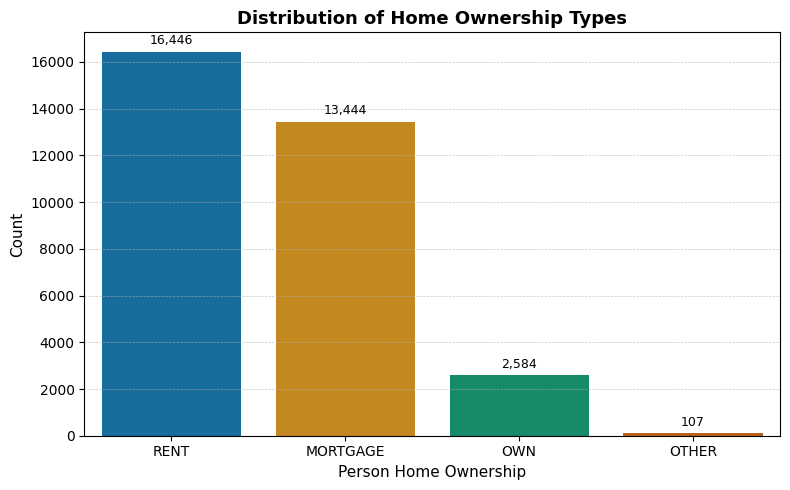

In [7]:
# Bar chart for person_home_ownership
plot_categorical_feature(
    data=data,
    column='person_home_ownership',
    chart_type='bar',
    title='Distribution of Home Ownership Types'
)


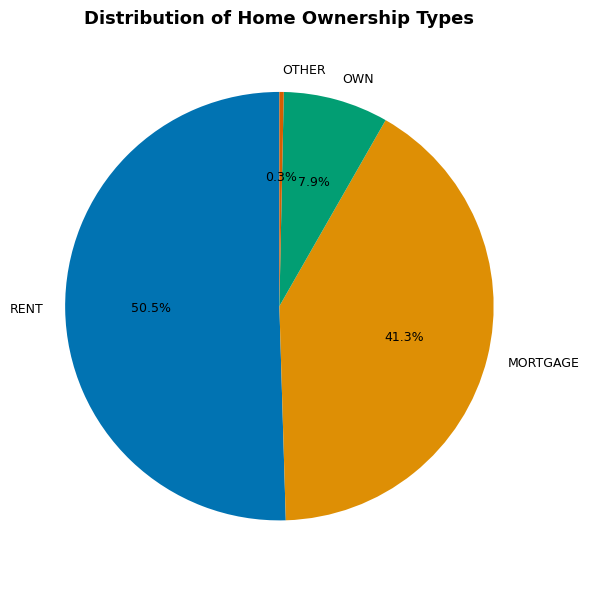

In [8]:
# Bar chart for person_home_ownership
plot_categorical_feature(
    data=data,
    column='person_home_ownership',
    chart_type='pie',
    title='Distribution of Home Ownership Types'
)


**Bar and Pie Chart: person_home_ownership**  
**Dominant Category:** "Rent" is the largest group, suggesting lower financial stability among applicants.  
**Pattern:** "Rent" and "Mortgage" together account for over 90% of the distribution, indicating that most applicants do not fully own their homes.  
**Actionable Insight:** Homeownership type may indicate financial dependency and could be predictive of default risk.

---

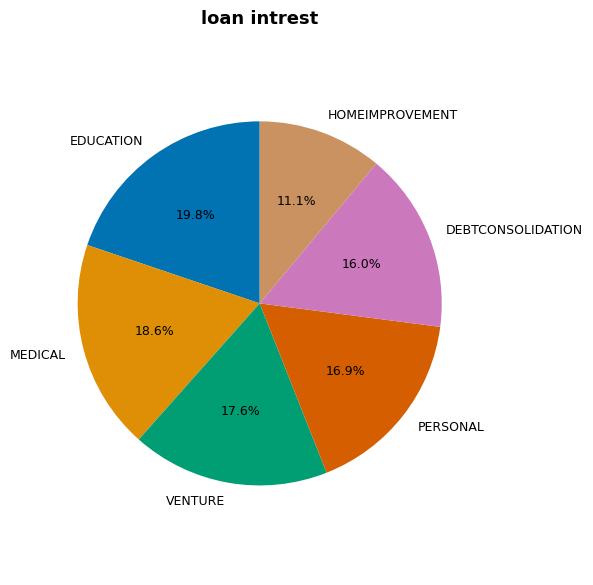

In [16]:
# Pie chart for loan_intent
plot_categorical_feature(
    data=data,
    column='loan_intent',
    chart_type='pie',
    title='loan intrest'
)


**Pie Chart: loan_intent**  
**Balanced Categories:** No single loan intent dominates. Categories such as education, medical, venture, and personal are relatively close in proportion.  
**Notable Slice:** "Home improvement" is the smallest category and may have limited impact unless strongly associated with default risk.  
**Actionable Insight:** Segmenting loan intent may reveal behavioral drivers of default and could be useful for modeling.

---


C:\Users\amine\AppData\Local\Temp\ipykernel_16548\4076231281.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=values, palette=base_colors)


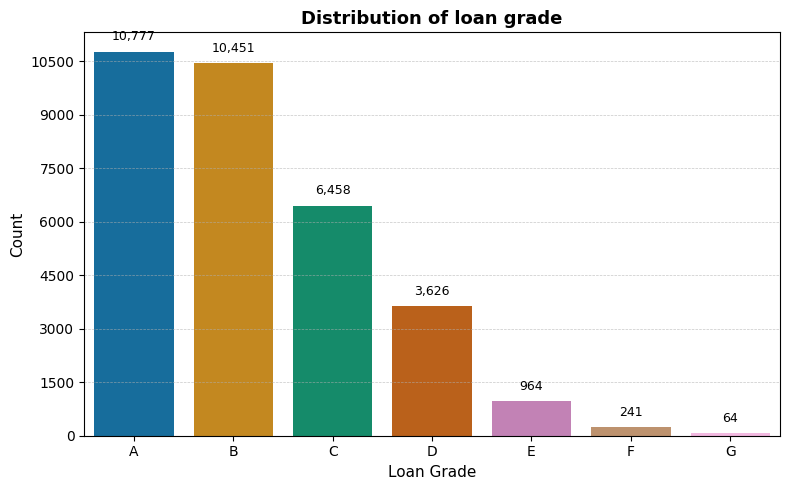

In [17]:
# Bar chart for loan_grade   
plot_categorical_feature(
    data=data,
    column='loan_grade',
    chart_type='bar',
    title='Distribution of loan grade'
)


**Bar Chart: loan_grade**  
**Skewed Distribution:** Grades A and B are the most common, indicating loans are primarily issued to low-risk applicants.  
**Anomaly:** Grades F and G are extremely rare and may pose challenges for modeling due to class imbalance.  
**Actionable Insight:** Consider combining lower grades or applying class weighting if loan grade is used as a predictor.

---

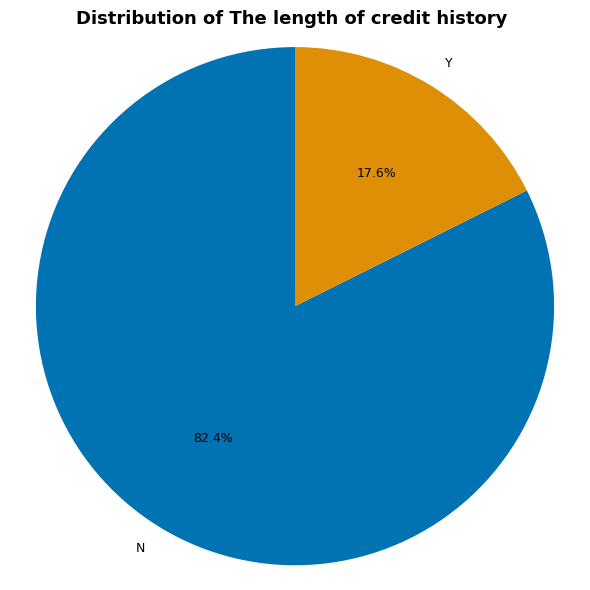

In [18]:
# Bar chart for cb_person_default_on_file
plot_categorical_feature(
    data=data,
    column='cb_person_default_on_file',
    chart_type='pie',
    title='Distribution of The length of credit history '
)


**Pie Chart: cb_person_default_on_file**  
**Imbalance:** A large majority of applicants (82%) have no prior default history, leading to a strong class imbalance.  
**Actionable Insight:** While this variable may be a strong predictor, care must be taken to prevent the model from becoming biased toward the majority class.


### Categorical Features vs. Target (`loan_status`)

In [19]:
# Display grouped bar chart comparing category distributions across the loan_status classes
def plot_grouped_bar_by_target(data, feature, target='loan_status', title=None):
    """
    Plots a grouped bar chart comparing category counts across target classes.

    Parameters:
    - data: pandas DataFrame
    - feature: str, name of the categorical feature
    - target: str, target variable (default='loan_status')
    - title: str, custom chart title
    """

    # Prepare data
    count_data = pd.crosstab(data[feature], data[target])
    count_data_percent = count_data.div(count_data.sum(1), axis=0) * 100
    count_data = count_data.sort_values(by=0, ascending=False)  # Sort by majority class

    # Plot setup
    categories = count_data.index
    classes = count_data.columns
    x = range(len(categories))

    width = 0.35
    colors = sns.color_palette("colorblind", len(classes))
    
    plt.figure(figsize=(10, 6))
    for i, cls in enumerate(classes):
        plt.bar(
            [p + width * i for p in x],
            count_data[cls],
            width=width,
            label=f"{target} = {cls}",
            color=colors[i]
        )

    # Labels & Axis
    plt.xlabel(feature.replace('_', ' ').title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks([p + width * (len(classes) - 1) / 2 for p in x], categories, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title or f"Distribution of {feature.replace('_', ' ').title()} by {target.title()}", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add count labels
    for i, cls in enumerate(classes):
        for j, val in enumerate(count_data[cls]):
            if val > 0:
                plt.text(j + width * i, val + max(count_data.values.flatten()) * 0.01, str(val), ha='center', fontsize=8)

    plt.legend(title='Class', fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.show()


In [27]:
#  visualize default rate per category, which is crucial for understanding how the target (loan_status) 
# behaves across different classes of a categorical feature.
def plot_target_rate_per_category(data, feature, target='loan_status', title=None):
    """
    Plots a normalized stacked bar chart showing default rate (target=1) per category.
    """
    import matplotlib.pyplot as plt

    # Prepare data
    grouped = data.groupby(feature)[target].value_counts(normalize=True).unstack().fillna(0)
    grouped = grouped[[0, 1]] if 0 in grouped.columns and 1 in grouped.columns else grouped
    categories = grouped.index.tolist()
    colors = ['#4C72B0', '#DD8452']  # blue = non-default, orange = default

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    grouped.plot(kind='bar', stacked=True, color=colors, edgecolor='black', ax=ax)

    # Titles and Labels
    ax.set_title(title or f"Default Rate by {feature.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel("Proportion", fontsize=12)
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks(ax.get_yticks())
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Annotations
    for i, (_, row) in enumerate(grouped.iterrows()):
        default_rate = row[1] if 1 in row else 0
        if default_rate > 0:
            ax.text(i, row[0] + 0.02, f"{default_rate:.0%}", ha='center', fontsize=9, fontweight='bold')

    # Legend – placed outside to the right
    ax.legend(['Non-Default (0)', 'Default (1)'], title='Loan Status', loc='center left',
              bbox_to_anchor=(1.0, 0.5), fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.show()


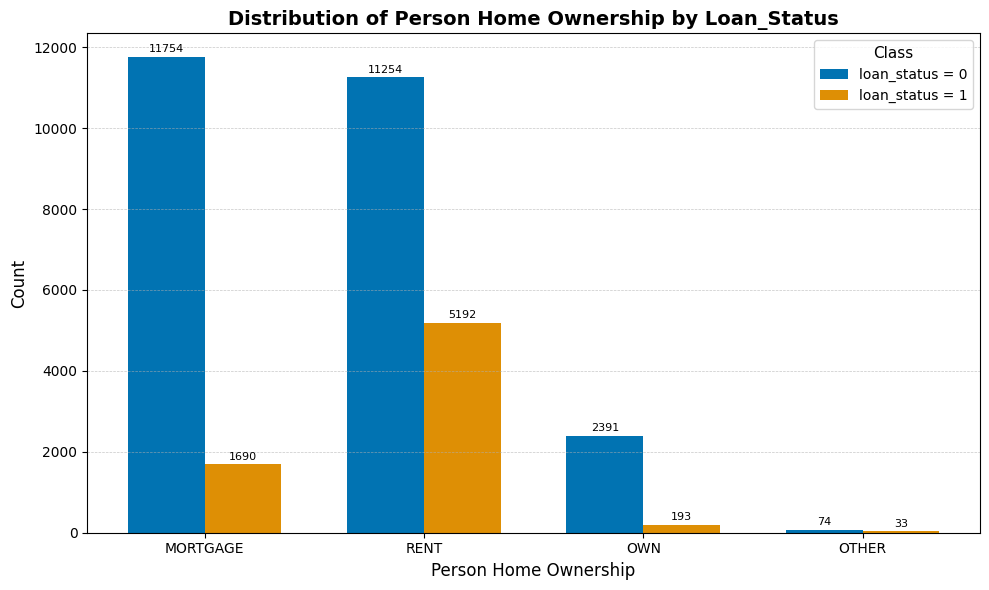

In [20]:
# Grouped bar chart for person_home_ownership vs. loan_status
plot_grouped_bar_by_target(data, feature='person_home_ownership', target='loan_status')


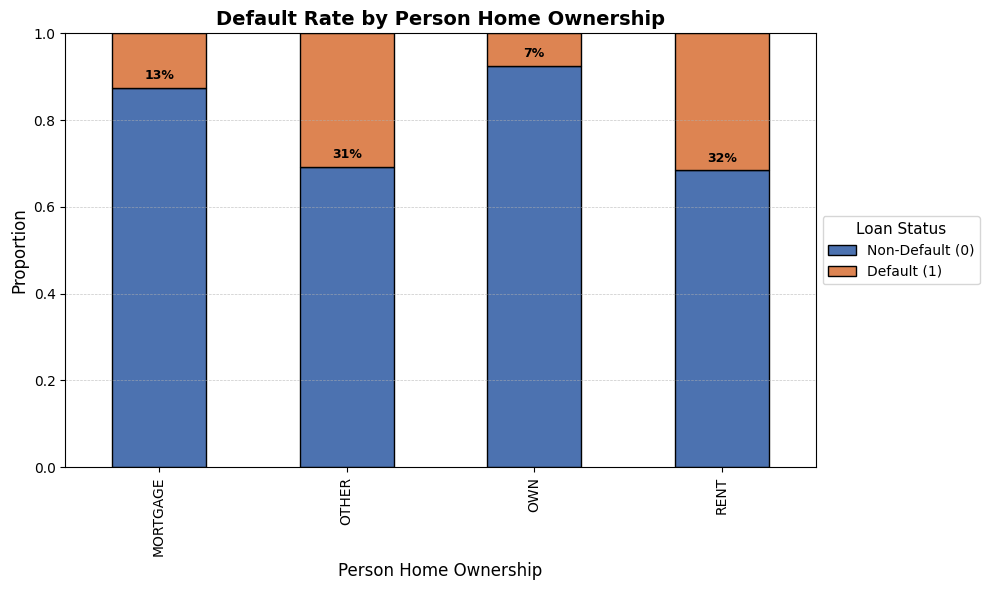

In [28]:
# Visualize default rate per home ownership type
plot_target_rate_per_category(data, feature='person_home_ownership')


**Interpretation: person_home_ownership**

**Default Risk Insight**  
Renters and the "Other" category exhibit significantly higher default rates (32% and 31%) compared to homeowners (7%) and mortgage holders (13%).

**Hypothesis**  
Lack of property ownership may reflect lower financial security, contributing to increased credit risk.

**Modeling Impact**  
This feature is a strong candidate for risk segmentation or interaction with variables such as income or employment length.

**Warning**  
The "Other" group is small and subject to high variance. Interpret with caution or consider merging with similar categories if found to be unstable.


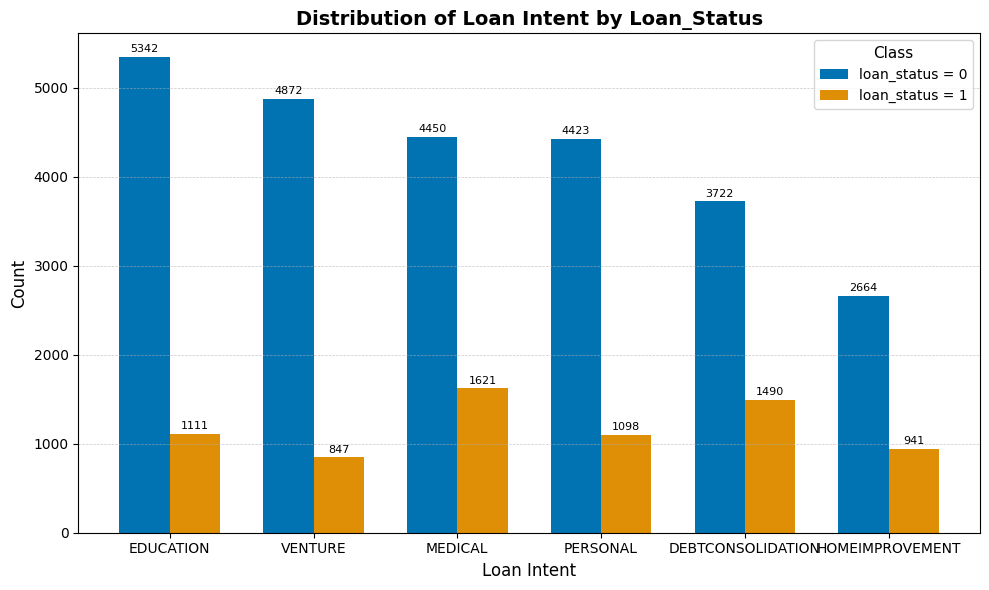

In [31]:
# Grouped bar chart for loan_intent vs. loan_status
plot_grouped_bar_by_target(data, feature='loan_intent', target='loan_status')

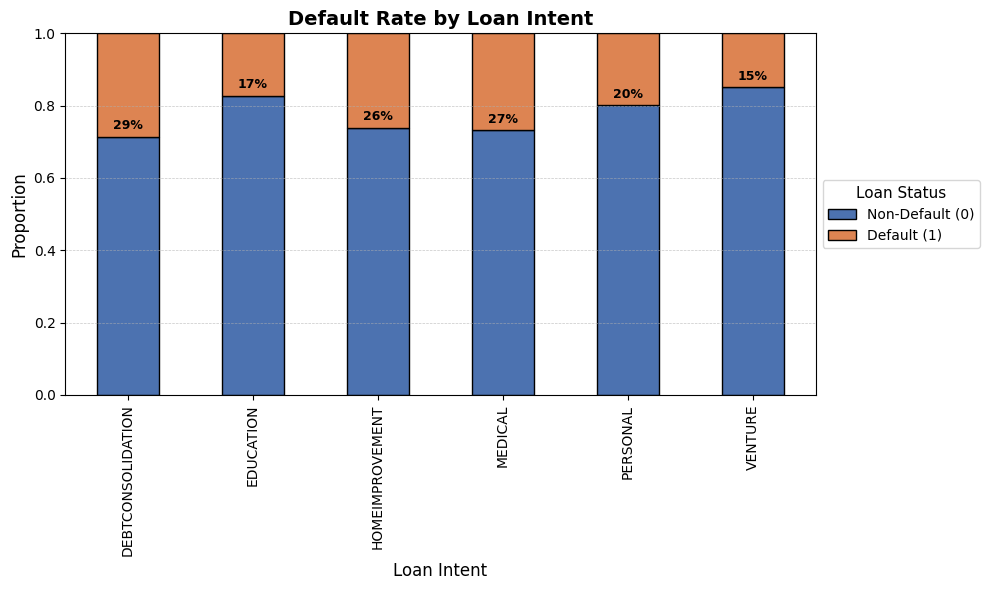

In [34]:
# Visualize loan_intent type
plot_target_rate_per_category(data, feature='loan_intent')

**Interpretation: loan_intent**

**Default Risk Insight**  
The highest default rates are observed for Debt Consolidation, Medical, and Home Improvement loans (26–29%). These categories may be associated with financial stress or unplanned expenses.

**Stable Segments**  
Venture and Education loans show relatively low default rates (≤17%), possibly reflecting more deliberate or growth-oriented borrowing behavior.

**Hypothesis**  
Loan purpose likely reflects the applicant’s financial stability and may capture latent factors such as urgency, planning ability, or credit discipline.

**Modeling Impact**  
Loan intent has strong predictive potential. It is recommended to encode this feature with consideration for risk-based groupings or clusters.


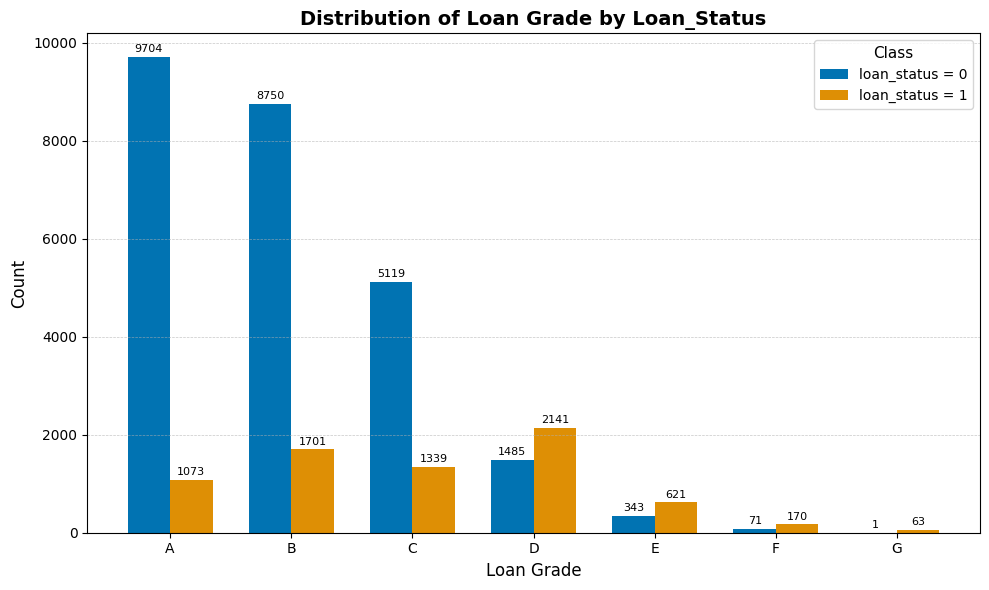

In [32]:
# Grouped bar chart for loan_grade vs. loan_status
plot_grouped_bar_by_target(data, feature='loan_grade', target='loan_status')

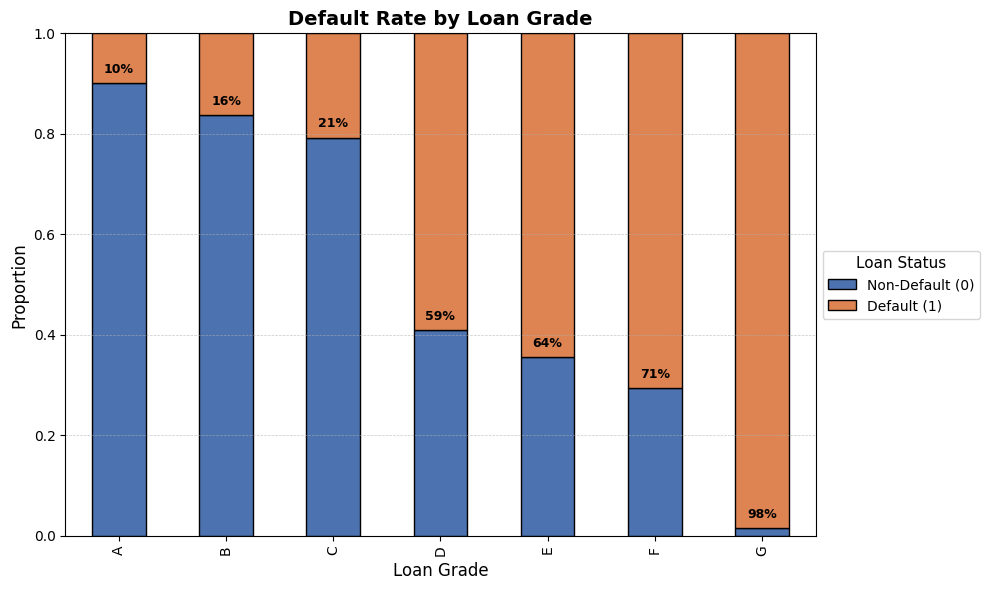

In [35]:
# Visualize loan_grade type
plot_target_rate_per_category(data, feature='loan_grade')

**Interpretation: loan_grade**

**Clear Risk Gradient**  
Default rates increase consistently from Grade A (10%) to Grade G (98%), indicating a strong ordinal relationship with credit risk.

**Statistical Value**  
This feature is highly informative as it inherently captures creditworthiness. It serves as a composite risk proxy, reflecting multiple underlying factors.

**Caution**  
Grades F and G are underrepresented in the dataset. Their predictive value should be validated before being heavily relied upon during model training.

**Modeling Tip**  
Consider treating this feature as ordinal. Alternatively, use target encoding or binning methods to preserve its risk structure while improving model compatibility.


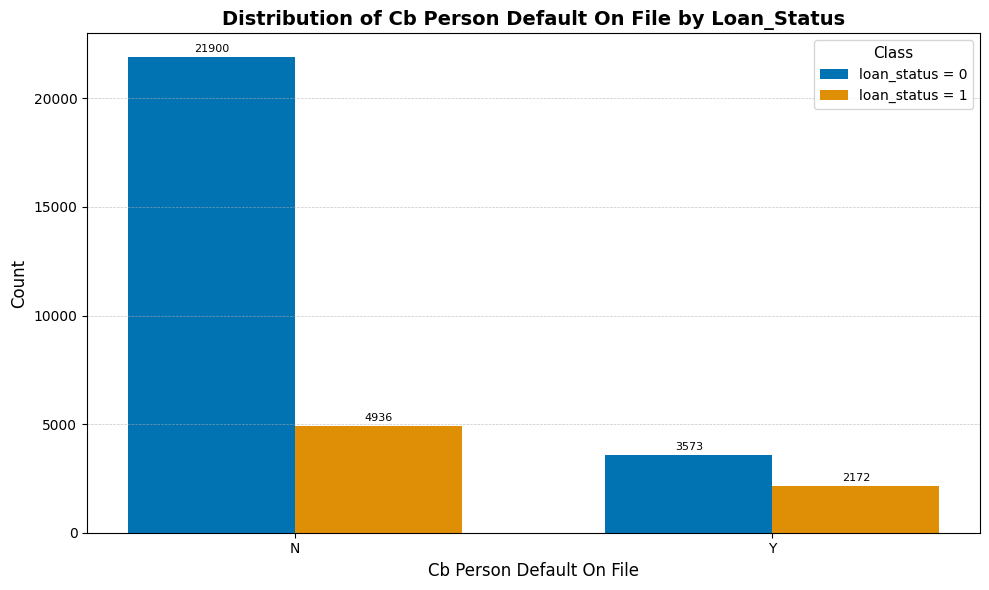

In [33]:
# Grouped bar chart for cb_person_default_on_file vs. loan_status
plot_grouped_bar_by_target(data, feature='cb_person_default_on_file', target='loan_status')

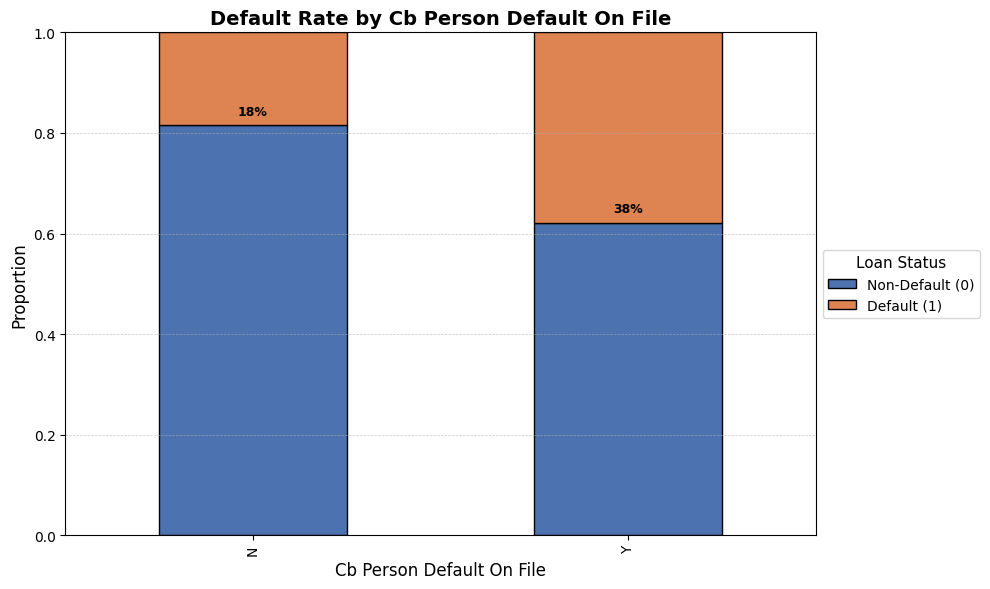

In [36]:
# Visualize cb_person_default_on_file type
plot_target_rate_per_category(data, feature='cb_person_default_on_file')

**Interpretation: cb_person_default_on_file**

**Predictive Power**  
Applicants with a prior default history exhibit a much higher default rate (18% compared to 38%), making this a strong binary indicator of credit risk.

**Statistical Signal**  
The feature highlights the persistence of credit behavior, where past delinquency is a strong predictor of future default.

**Modeling Use**  
This is a high-priority feature for credit scoring models. It can be used as-is or in interaction with variables such as credit history length or loan grade to enhance predictive performance.


### Statistical Significance (Chi-Square Test)

**Hypotheses to Test (Chi-Square of Independence)**

For each of the tests below, assumptions such as minimum expected frequency (≥ 5) will be verified. The Chi-square test will be applied if assumptions are met; otherwise, Fisher's Exact Test will be used.

---

**1. person_home_ownership vs loan_status**  
**Null Hypothesis (H₀):** Home ownership type is independent of default status.  
**Alternative Hypothesis (H₁):** Home ownership type is associated with default status.

---

**2. loan_intent vs loan_status**  
**Null Hypothesis (H₀):** Loan intent is independent of default status.  
**Alternative Hypothesis (H₁):** Loan intent is associated with default status.

---

**3. loan_grade vs loan_status**  
**Null Hypothesis (H₀):** Loan grade is independent of default status.  
**Alternative Hypothesis (H₁):** Loan grade is associated with default status.

---

**4. cb_person_default_on_file vs loan_status**  
**Null Hypothesis (H₀):** Credit bureau default history is independent of loan status.  
**Alternative Hypothesis (H₁):** Credit bureau default history is associated with loan status.

---

These tests will help determine whether the observed differences in default rates across categories are statistically significant rather than purely visual patterns.


In [42]:
def chi_squared_test(df, cat_feature, target):
    """
    Perform Chi-Squared or Fisher’s Exact Test based on assumptions.
    Ensures all statistical conditions are checked and errors are avoided.
    """
    result = {}

    # Drop missing values from the relevant columns
    data = df[[cat_feature, target]].dropna()

    # Step 1: Create contingency table
    table = pd.crosstab(data[cat_feature].astype(str), data[target].astype(str))
    result['Contingency Table'] = table

    try:
        # Step 2: Expected frequencies and assumption check
        chi2, p, dof, expected = chi2_contingency(table)
        expected_df = pd.DataFrame(expected, index=table.index, columns=table.columns)
        valid = (expected >= 5).all()

        result['Expected Frequencies'] = expected_df
        result['Min Expected'] = expected.min()
        result['Valid for Chi²'] = valid

        # Step 3: Choose test based on assumptions
        if valid:
            result['Test'] = 'Chi-Squared'
            result['Chi² Statistic'] = chi2
            result['Degrees of Freedom'] = dof
            result['p-value'] = p
        else:
            if table.shape == (2, 2):
                _, fisher_p = fisher_exact(table)
                result['Test'] = "Fisher's Exact Test"
                result['Chi² Statistic'] = None
                result['Degrees of Freedom'] = 1
                result['p-value'] = fisher_p
            else:
                result['Test'] = "Chi-Squared (Warning: some expected freq < 5)"
                result['Chi² Statistic'] = chi2
                result['Degrees of Freedom'] = dof
                result['p-value'] = p

        result['Significant (p<0.05)'] = result['p-value'] < 0.05
        result['Conclusion'] = "Reject H₀ → Association exists" if result['Significant (p<0.05)'] else "Fail to Reject H₀ → No association"

        return pd.DataFrame.from_dict(result, orient='index', columns=['Value'])

    except Exception as e:
        return f"❌ Error during test: {e}"


In [43]:
chi_squared_test(data, 'person_home_ownership', 'loan_status')


'❌ Error during test: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.'

In [ ]:
## 3. Numerical Variable Analysis
### 3.1 Correlation Matrix and Heatmap
### 3.2 Statistical Significance (e.g., ANOVA / t-test)
### 3.3 Interaction Exploration (e.g., scatter plots, segment trends)

In [ ]:
## 4. Key Findings and Insights
### 4.1 Summary of Significant Variables
### 4.2 Notes for Feature Engineering and Modeling
